In [1]:
import cards as ccg
import pandas as pd
import numpy as np
import copy
import random
import torch
seed = 12345644

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

cards = pd.read_csv('cardsTable.csv')
cardsList = [ccg.Minion(i) for i in cards.values.tolist()]

cores = pd.read_csv('cores.csv')
coreList = [ccg.Core(i) for i in cores.values.tolist()]

playersNum = 2
piles = [[ccg.Pile(cardsList, 10) for _ in range(4)] for I in range(playersNum)]
cores = np.random.choice(coreList, 2)
decks = [ccg.Deck(cores[i], piles[i], i) for i in range(playersNum)]

In [2]:
session = ccg.Session(decks)

In [3]:
def envActionFromAction(action, home_turn):
    #skip
    env_action = ("skip")
    if action == 0:
        return env_action
    
    #attack core
    action -= 1
    if(action < 7):
        env_action = ("attack", [home_turn, action], [1 - home_turn, 0])
        return env_action
    
    #attack unit
    action -= 7
    if(action < 49):
        env_action = ("attack", [home_turn, action // 7], [1 - home_turn, action % 7])
        return env_action
    
    #play from pile
    action -= 49
    if(action < 4):
        env_action = ("play", action)
        return env_action
    
    #play from hand
    action -= 4
    if(action < 6):
        env_action = ("play_hand", action)
        return env_action
    
    #move from pile to hand
    action -= 6
    env_action = ("move", action)
    if action < 4:
        return env_action
    return None

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
session.reset()
print(session.getObservation()["hands"])
print(session.getValidActions())
session.action(('move', 1))
session.action(('move', 2))
session.action(('move', 3))
print(session.getObservation()["hands"])
print(session.getValidActions())
session.action(('play_hand', 0))
print(session.getObservation()["hands"])
print(session.getValidActions())

[(0, []), (0, [])]
['skip', ('play', 1), ('move', 0), ('move', 1), ('move', 2), ('move', 3)]
[(3, [(1, 2, 0, 1, 1, True), (2, 2, 0, 3, 3, True), (2, 2, 0, 3, 3, True)]), (0, [])]
['skip', ('play_hand', 0), ('move', 0), ('move', 1), ('move', 2), ('move', 3)]
[(2, [(2, 2, 0, 3, 3, True), (2, 2, 0, 3, 3, True)]), (0, [])]
['skip', ('move', 0), ('move', 1), ('move', 2), ('move', 3)]


In [24]:
actionDistr = [0] * 71
numActions = [0] * 71

In [25]:
from IPython.display import clear_output
import copy
for i in range(10000):
    endGame = False
    print(i)
    while not endGame:
        actions = session.reset()
        while not endGame:  
            actions = session.getValidActions()
            state = session.getObservation()
            numActions[len(actions)] += 1
            for i in range(71):
                action = envActionFromAction(i, state["turn"])
                if(action in actions):
                    actionDistr[i] += 1
            if (len(actions) > 1):
                act = random.choice(actions[1:])
                state = session.action(act)
            else:
                state = session.action(actions[0])
            endGame = state["end"]
            
    clear_output(True)

9999


In [26]:
for i in range(71):
    print(envActionFromAction(i, 0), actionDistr[i])

skip 2988566
('attack', [0, 0], [1, 0]) 0
('attack', [0, 1], [1, 0]) 832271
('attack', [0, 2], [1, 0]) 510991
('attack', [0, 3], [1, 0]) 274801
('attack', [0, 4], [1, 0]) 123040
('attack', [0, 5], [1, 0]) 44352
('attack', [0, 6], [1, 0]) 11874
('attack', [0, 0], [1, 0]) 0
('attack', [0, 0], [1, 1]) 0
('attack', [0, 0], [1, 2]) 0
('attack', [0, 0], [1, 3]) 0
('attack', [0, 0], [1, 4]) 0
('attack', [0, 0], [1, 5]) 0
('attack', [0, 0], [1, 6]) 0
('attack', [0, 1], [1, 0]) 832271
('attack', [0, 1], [1, 1]) 798127
('attack', [0, 1], [1, 2]) 656507
('attack', [0, 1], [1, 3]) 426880
('attack', [0, 1], [1, 4]) 223981
('attack', [0, 1], [1, 5]) 95192
('attack', [0, 1], [1, 6]) 31868
('attack', [0, 2], [1, 0]) 510991
('attack', [0, 2], [1, 1]) 492316
('attack', [0, 2], [1, 2]) 438021
('attack', [0, 2], [1, 3]) 316408
('attack', [0, 2], [1, 4]) 179231
('attack', [0, 2], [1, 5]) 80276
('attack', [0, 2], [1, 6]) 27876
('attack', [0, 3], [1, 0]) 274801
('attack', [0, 3], [1, 1]) 265915
('attack', [0

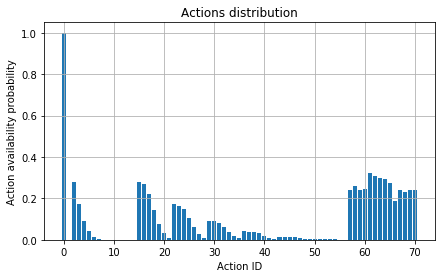

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.ylabel('Action availability probability')
plt.xlabel('Action ID')
plt.title('Actions distribution')
plt.bar([i for i in range(71)], np.array(actionDistr) / max(actionDistr))
plt.grid(True)
plt.show()

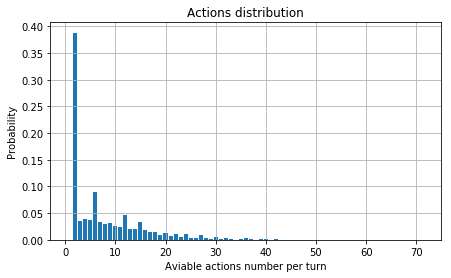

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.xlabel('Aviable actions number per turn')
plt.ylabel('Probability')
plt.title('Actions distribution')
plt.bar([i + 1 for i in range(71)], np.array(numActions) / sum(numActions))
plt.grid(True)
plt.show()